### Make initial conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import gsw
import tqdm
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask
from nemo_python.utils import fix_lon_range, convert_to_teos10

In [2]:
# File locations on Jasmin:
folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
folder_BC   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/'
folder_NEMO = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

# Load files:
nemo = xr.open_dataset(f'{folder_NEMO}coordinates_AIS.nc').squeeze()
nemo_mask = xr.open_dataset(f'{folder_NEMO}mesh_mask-20231025.nc')
sose      = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m01.nc')
domcfg    = xr.open_dataset(f'{folder_NEMO}domain_cfg-20231025.nc')

nemo_depths = nemo_mask.nav_lev.values

In [6]:
nemo_domcfg = xr.open_dataset(f'{folder_NEMO}domain_cfg-20231025.nc')

#### Functions

In [3]:
# Function to compute edges of the z-levels
# Inputs:
# mesh:
# mtype: string name specifying the mesh type (currently only includes nemo and SOSE)
# source_file: --- > "sose"
def vertical_edges(mesh, mtype='nemo'):

    if mtype=='nemo':    # 2D
        z_centres = mesh.gdept_0.isel(time_counter=0).values
        dz        = mesh.e3t_0.isel(time_counter=0).values
    elif mtype=='SOSE':  # 1D --> 2D
        z_centres, _ = xr.broadcast(-1*sose.Z, mesh[list(mesh.keys())[0]].isel(z=0))
        dz, _        = xr.broadcast(sose.drF, mesh[list(mesh.keys())[0]].isel(z=0))
        
        z_centres = z_centres.values
        dz        = dz.values
    else:
        print('Only mesh types included are nemo and SOSE')

    z_top_edge = z_centres - 0.5*dz
    z_bot_edge = z_centres + 0.5*dz
    
    z_top_edge[z_top_edge < 0] = 0
    
    return (z_top_edge, z_centres, z_bot_edge)

In [15]:
# Helper function to convert an xarray dataset with 3D T and S to TEOS10 (absolute salinity and conservative temperature)
# Inputs: 
# dataset: xarray dataset containing variables lon, lat, depth, and THETA (potential temperature) or SALT (practical salinity)
# var:     string of variable name to convert: THETA or SALT
def convert_to_teos10(dataset, var='SALT'):
    # Convert to TEOS10
    # Need 3D lat, lon, pressure at every point, so if 1D or 2D, broadcast to 3D
    if dataset.lon.values.ndim <= 2:
        lon   = xr.broadcast(dataset['lon'], dataset[var])[0]
    if dataset.lat.values.ndim <= 2:
        lat   = xr.broadcast(dataset['lat'], dataset[var])[0]
    if dataset.depth.values.ndim <= 2:
        # Need pressure in dbar at every 3D point: approx depth in m
        press = np.abs(xr.broadcast(dataset['depth'], dataset[dataset_var])[0])
    else:
        press = np.abs(dataset['depth'])
    
    if var=='SALT':
        # Get absolute salinity from practical salinity
        absS  = gsw.SA_from_SP(dataset[var], press, lon, lat)

        return absS
    elif var=='THETA':    
        if 'SALT' in list(dataset.keys()):
            # Get absolute salinity from practical salinity
            absS  = gsw.SA_from_SP(dataset['SALT'], press, lon, lat)
            # Get conservative temperature from potential temperature
            consT  = gsw.CT_from_t(absS, dataset[var], press)
        else:
            raise Exception('Must include practical salinity (SALT) variable in dataset when converting potential temperature'
        
        return consT
    else:
        raise Exception('Variable options are SALT or THETA')

In [19]:
# def IC_horizontal_interp(source='SOSE', variable='SALT', 
#                          folder_ICs='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/', 
#                          in_file='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc',
#                          salt_file='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc',
#                          nemo_coord  ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/coordinates_AIS.nc'
#                          source_coord='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc'):
def IC_horizontal_interp(interp_info, in_file, out_file):
    
    # Load files:
    nemo_coord_file   = xr.open_dataset(f'{interp_info.nemo_coord}').squeeze()
    
    # Specify coordinate names:
    if interp_info.source=='SOSE':
        name_remapping = {'XC':'lon', 'YC':'lat', 'Z':'depth'}
    else:
        raise Exception('Only currently set up for reading SOSE')

    # Read variable and slice to the latitude range of interest to reduce size
    source_var = xr.open_dataset(f'{in_file}').rename(name_remapping).sel(lat=slice(-90, -48))
    if source_var.lon.max() > 180: # Convert longitudes from 0-360 to -180 to 180 
        source_var['lon'] = fix_lon_range(source_var.lon)
        source_var        = source_var.sortby('lon') 
    
    # convert temperature and salinity values to TEOS10:
    if interp_info.variable == 'SALT':
        print(f'Converting {interp_info.variable} to TEOS10')    
        source_converted = convert_to_teos10(source_var, var=interp_info.variable)
    elif interp_info.variable == 'THETA':
        print(f'Converting {interp_info.variable} to TEOS10')
        print('Note: to convert potential temperature to conservative temperature, TEOS10 uses absolute salinity. Make sure a salinity file is specified.')
        source_salt        = xr.open_dataset(f'{interp_info.salt_file}').rename(name_remapping).sel(lat=slice(-90, -48))    
        source_salt['lon'] = fix_lon_range(source_salt.lon)
        source_salt        = source_salt.sortby('lon') 
        source_dataset     = source_var.assign('SALT':source_salt['SALT'])
        source_converted   = convert_to_teos10(source_dataset, var=variable)
    else:
        source_converted   = source_var[interp_info.variable]

    print(f'Horizontally interpolating each depth level in {interp_info.source} dataset to NEMO grid')
    datasets = []
    # Loop over all source dataset depth levels:
    for dl in tqdm.tqdm(range(source_var.Z.size)):
        if interp_info.source == 'SOSE':
            # Mask values that are on land in the source dataset
            var_source = xr.where(source_var.maskC.isel(depth=dl)==1, source_converted.isel(depth=dl), np.nan)
            var_source = xr.where(var_source==0, np.nan, var_source)
            # Now wrap up into a new Dataset
            ds_source = xr.Dataset({'lon':SOSE['lon'], 'lat':SOSE['lat'], variable:var_source}) 
            
            # Interpolate slices of depth levels along lat-lon (horizontally)
            interp_src = interp_latlon_cf(ds_source, nemo_coord_file, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
            
            datasets.append(interp_src)
    
    source_interpolated = xr.concat(datasets, dim='z').assign_coords(z=np.abs(source_var.Z.values[0:dl+1]))
    source_interpolated.to_netcdf(f'{out_file}')
    
    return

In [6]:
# Function that is called by vertical_interp to actually perform the vertical interpolation
# Inputs:
# source: 
# source_edges:
# nemo_edges:
# n:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:,:]; NEMO_bot_edge = nemo_edges[2][n,:,:];

    dataset = xr.Dataset({}) #.assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        Var = 0; 
        for zs in range(0,source.z.size):
            src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Var + (NEMO_bot_edge - NEMO_top_edge)* (source.isel(z=zs)), Var)

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Var + (src_bot_edge - NEMO_top_edge) * source.isel(z=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (NEMO_bot_edge - src_top_edge) * source.isel(z=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (src_bot_edge - src_top_edge) * source.isel(z=zs), Var)

            # if the SOSE bottom grid cell is shallower than the WOA bottom grid cell, the value of the cell is NaN
        
        Var = Var/(NEMO_bot_edge - NEMO_top_edge)
        dataset[var] = (('y', 'x'), Var[var].values)
        
    return dataset

## Main

In [7]:
SOSE_hinterp_salt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/salt-horizontal-interp.nc')

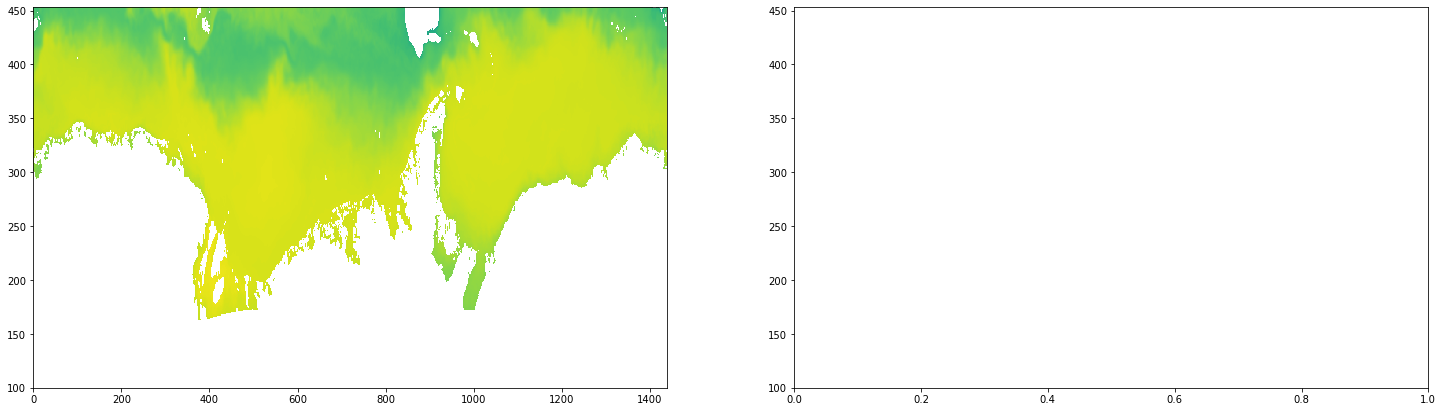

In [7]:
int=28
vminm=33
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].pcolormesh(SOSE_hinterp_salt.SALT.isel(z=int).values, vmin=vminm, vmax=vmaxm)
# ax[1].pcolormesh(theta_extended[45,:,:], vmin=vminm, vmax=vmaxm)

for axis in ax.ravel():
    axis.set_ylim(100,453)

In [8]:
# Function to vertically interpolate the specified variable
# Inputs:
# interp_info: dictionary containing 'nemo_mask', 'source_coord', 'variable', 'source' 
# in_file: string name of input file
# out_file: string name of output file
def vertical_interp(interp_info, in_file, out_file):

    # Load horizontally interpolated variable:
    hinterp_var = xr.open_dataset(f'{in_file}')
    
    # Find edges of the NEMO and source dataset vertical levels: 
    nemo_mask_file    = xr.open_dataset(f'{interp_info.nemo_mask}')
    source_coord_file = xr.open_dataset(f'{interp_info.source_coord}')
    nemo_edges        = vertical_edges(nemo_coord_file, mtype='nemo')
    source_edges      = vertical_edges(source_coord_file, mtype=interp_info.source)    

    # Loop over vertical NEMO levels to interpolate slices from the source dataset:
    print(f'Vertically interpolating variable {interp_info.variable}')
    model_ICs = []
    for n in tqdm.tqdm(range(len(nemo_mask.nav_lev.values))):
        data_interp = interp_depth(hinterp_var, source_edges, nemo_edges, n)
        model_ICs.append(data_interp) # Add interpolated layers to dataset
    
    source_interp = xr.concat(model_ICs, dim='z') 
    
    # write to file
    source_interp.to_netcdf(f'{out_file}')
    
    return

In [9]:
# Helper function to fill the bottom grid cell with values from above to avoid any issues with edges
# Inputs:
# variable: string name of variable that is being interpolated/filled
# file_interp: string name of file produced by vertical_interp function (horizontally and vertically interpolated variable, with missing points not yet filled)
def fill_near_bottom(variable, file_interp):
    # Load file that contains vertical and horizontally interpolated variable:
    var_interp = xr.open_dataset(file_interp)
    
    # fill only those cells that are nearest the bottom with nearest neighbour instead of NaN
    Var_masked = np.ma.masked_where(np.isnan(var_interp[variable].values), var_interp[variable].values)
    ind_array  = np.ma.notmasked_edges(Var_masked, axis=0)
    bottom_ind = ind_array[1][0][:] + 1 # list of Z level associated with each of the y cells
    bottom_ind[bottom_ind>=var_interp.z.size] = var_interp.z.size-1 # max python grid value
    lat_ind    = ind_array[1][1][:] 
    lon_ind    = ind_array[1][2][:]
        
    for i, bot in enumerate(bottom_ind):
        Var_masked[bottom_ind[i], lat_ind[i], lon_ind[i]] = Var_masked[bottom_ind[i]-1, lat_ind[i], lon_ind[i]]
        
    var_interp[variable] = (('z','y','x'), Var_masked.data)
    
    return var_interp

In [10]:
# Helper function to fill missing values (empty cavities) in interpolated source dataset with the connected nearest neighbour 
# Inputs:
# variable: string name of the variable to be filled
# fill_val: the temporary fill value assigned to values in the source dataset that are masked
# niter: maximum number of iterations used to fill connected nearest neighbours
def fill_mask(input_dataset, variable, nemo_mask, fill_val=1000, niter=100):
    
    print('Filling gaps with connected nearest neighbours')
    
    nemo_ocn     = (nemo_mask.tmask.isel(time_counter=0) != 0)
    src_to_fill  = xr.where(np.isnan(input_dataset[variable].values)*nemo_ocn, fill_val, input_dataset[variable].values)
    var_filled   = extend_into_mask(src_to_fill.values, missing_val=fill_val)
    
    for iter in tqdm.tqdm(range(niter)):
        if sum(sum(sum(var_filled==fill_val))) == 0: # stop looping if all missing values have been filled
            break
        else:
            var_filled = extend_into_mask(var_filled, missing_val=fill_val) 

    input_dataset[variable] = (('z','y','x'), var_filled)
        
    return input_dataset 

In [25]:
# Main function to create inititial T, S conditions for NEMO configuration from a source, currently set up for B-SOSE
# Input:
# in_file: string location of file to be interpolated
# variable: string of name of variable in in_file to be interpolated
# dataset: string specifying the source of the dataset (currently only set up for 'SOSE')
# folder_ICs: string location of folder that contains all the relevant files to read in and that will be used to write output files
# Output:
# Three files: SOSE-SALT-horizontal-interp.nc, SOSE-SALT-vertical-interp.nc, SOSE-SALT-initial-conditions.nc

def create_ICs(variable, in_file, out_file,
               source='SOSE',
               source_coord='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/...',
               nemo_coord  ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/coordinates_AIS.nc',
               nemo_mask   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025.nc',
               salt_file   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc'):

    print(f'---- Creating NEMO initial conditions for variable {variable} from {source} ----')
                   
    if source=='SOSE':        

        # Dictionary specifying file names and locations for subsequent functions:
        interp_info = {'source':source,
                       'variable': variable,
                       'nemo_coord': nemo_coord,
                       'nemo_mask': nemo_mask,
                       'source_coord': source_coord,
                       'salt_file':salt_file}
    
        # Horizontally interpolate source dataset to NEMO grid:
        IC_horizontal_interp(interp_info, in_file, f'{in_file[:-3]}-horizontal-interp.nc')
        
        # Vertically interpolate the above horizontally interpolated dataset to NEMO grid:
        vertical_interp(interp_info, f'{in_file[:-3]}-horizontal-interp.nc', f'{in_file[:-3]}-vertical-interp.nc')
        
        # Fill values just above the bottom with their nearest neighbour:
        SOSE_interp_filled = fill_near_bottom(variable, f'{in_file[:-3]}-vertical-interp.nc')
        # Fill areas that are masked in source dataset but not in NEMO with nearest neighbours:
        SOSE_extended = fill_mask(SOSE_interp_filled, variable, nemo_mask)

        # Write output to file:
        SOSE_extended.to_netcdf(f'{out_file}')

        return
    else:
        raise Exception('Functions only set up for SOSE currently')

In [26]:
THETA_file_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/THETA_climatology_m01.nc';
output_file     = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/THETA-SOSE-initial-conditions.nc'

create_ICs('THETA', THETA_file_SOSE, output_file, 
           source       = 'SOSE',
           source_coord = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/...',
           nemo_coord   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/coordinates_AIS.nc',
           nemo_mask    = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025.nc',
           salt_file    = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')

-- Creating initial conditions for variable THETA from SOSE --
Converting THETA to TEOS10
Note: to convert potential temperature to conservative temperature, TEOS10 uses absolute salinity. Make sure correct salinity file is specified.
Horizontally interpolating each depth level in SOSE dataset to NEMO grid


  4%|▍         | 2/52 [07:42<3:12:37, 231.16s/it]


KeyboardInterrupt: 

In [19]:
vert_interp = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-vertical-interp.nc')

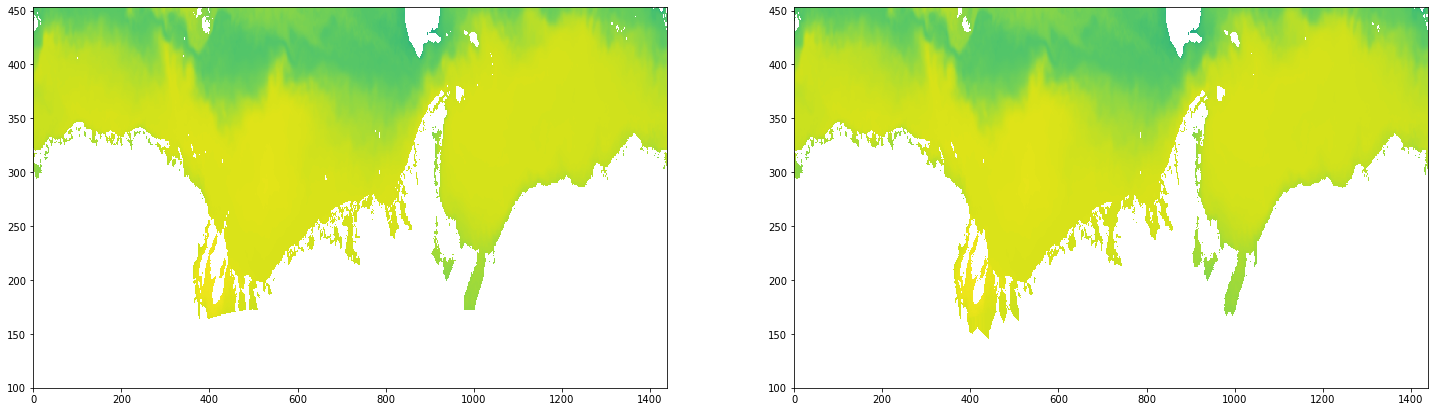

In [20]:
int=50
vminm=33
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].pcolormesh(vert_interp.SALT.isel(z=int), vmin=vminm, vmax=vmaxm)
ax[1].pcolormesh(SOSE_extended.SALT.isel(z=int), vmin=vminm, vmax=vmaxm)

for axis in ax.ravel():
    axis.set_ylim(100,453)